# QA Gen
a notebook that uses GroundX Parse to explore a document and generate question answer pairs.

The end result is a parallelized program which generates question/answer pairs in the background while rendering a simple html UI for human vetting in the front end. Accepted Q/A pairs are accumulated and returned in the final code block.

video: https://www.youtube.com/watch?v=fC6Jybh96Y4

In [25]:
"""Requires the following environment variables:
- GROUNDX_API_KEY
- OPENAI_API_KEY

Also, requires a document_id from uploading to GroundX. You can find a document
id by exploring the GroundX Dashboard.
"""

import os
from google.colab import userdata
#==== change these ====
os.environ['GROUNDX_API_KEY'] = userdata.get('GroundXAPIKey_daniel.warfield')
os.environ['OPENAI_API_KEY'] = userdata.get('OpenAIAPIKey')

"""A document uploaded to and stored on GroundX
"""
document_id = 'b33b825c-2b38-4631-908e-0a76479bf116'

In [1]:
!pip install groundx-python-sdk
! pip install -U openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.9/371.9 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 24.5 MB/s eta 0:00:00
  Attempting uninstall: cryptography
    Found existing installation: cryptography 43.0.3
    Uninstalling cryptography-43.0.3:
      Successfully uninstalled cryptography-43.0.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 389.6/389.6 kB 7.4 MB/s eta 0:00:00
  Attempting uninstall: openai
    Found existing installation: openai 1.54.3
    Uninstalling openai-1.54.3:
      Successfully uninstalled openai-1.54.3


# Getting XRay Parse Data

Getting the GroundX Parse results, aka xRay.

In [4]:
from pprint import pprint
from groundx import Groundx

groundx = Groundx(
    api_key=os.environ['GROUNDX_API_KEY']
)

response = groundx.documents.get(
    document_id=document_id
)

import urllib.request, json
with urllib.request.urlopen(response.body['document']['xrayUrl']) as url:
    xRayData = json.load(url)

document_url = response.body['document']['sourceUrl']

# Filtration
To make question answer pairs, we're only interested in chunks which have certain attributes. These could be modified depending on the use case.

Here, I don't want a bunch of chunks from a single page, so I'm filtering by that.

In [5]:
qa_generation_data = []

# Only allowing a certain number per page
max_per_page = 2  # Set your desired max per page
num_per_page = {}

for chunk in xRayData['chunks']:
    # Only using chunks where the content exists on a single page
    if len(chunk['pageNumbers']) != 1:
        continue

    # Only accepting chunks which have a single bounding box, for now
    if len(chunk['boundingBoxes']) != 1:
        pass

    # Get the page number for this chunk
    page_number = chunk['pageNumbers'][0]

    # Check if we've reached the max number of items for this page
    if num_per_page.get(page_number, 0) >= max_per_page:
        continue

    # Append data for generating QA pairs
    qa_generation_data.append({**chunk, 'documentUrl': document_url})

    # Increment the count for this page
    num_per_page[page_number] = num_per_page.get(page_number, 0) + 1

# Generating QA pairs from generation data

Generating a set of QA pairs. This code block defines the core prompt which informs the model of how to generate QA pairs. 5 QA pairs are hard coded to be easier on the LLM. These are what become a batch in future code blocks.

In [22]:
from openai import OpenAI
from pydantic import BaseModel, constr, Field
from typing import Dict

#defining client
client = OpenAI()

#defining base model for parsing
class QAModel(BaseModel):
    rationale: str
    question_1: str
    answer_1: str
    question_2: str
    answer_2: str
    question_3: str
    answer_3: str
    question_4: str
    answer_4: str
    question_5: str
    answer_5: str


def gen_qa_batch(gen_data):

    #creating context
    context = f'''Use the following data to generate question answer pairs:

{gen_data['suggestedText']}'''

    #querying the model
    response = client.beta.chat.completions.parse(
        model='gpt-4o-mini',
        messages=[
            {"role": "system", "content": '''You are tasked with turning data into
            a set of question answer pairs which will be used to test information
            extraction systems. it is your job to create a set of question and
            answer pairs which expore a wide range of topics and types of information

            first, look at the data and construct a "rationale". This rationale
            should include a breakdown of the types of information presented, and
            what an information extraction system might fail at when analyzing this
            type of data. Then, generate a batch of question-answer pairs
            that would adequetly test based on the rationale.

            Important considerations:
            - The question should be clear enough where a single answer can be found
            - There are tens if not hundreds of documents. Questions must be specific.
            - Avoid questions like "this figure", "in the section" and "in the document",
            as there are many documents.
            - The objective is to ask fair questions where a clear answer is obvious.'''
            },
            {"role": "user", "content": context},
        ],
        response_format=QAModel
    )

    #transforming the response into a more handy structure.
    data = dict(response.choices[0].message.parsed)

    transformed_data = {
        'rationale': data['rationale'],
        'questions_answers': [
            {'question': data[f'question_{i}'], 'answer': data[f'answer_{i}']}
            for i in range(1, 6)
        ]
    }

    #adding additional information that's important for rendering:
    result = {**transformed_data,
              'documentUrl':gen_data['documentUrl'],
              'pageNumbers':gen_data['pageNumbers'],
              'boundingBoxes':gen_data['boundingBoxes']}

    return result

gen_qa_batch(qa_generation_data[1])

{'rationale': "The provided data consists of a list of defect descriptions and definitions related to Walmart's supply chain process. Each defect highlights an issue that can occur during the supply of goods, along with a brief explanation of the discrepancy. An information extraction system may face challenges distinguishing nuances between similar defects (e.g., 'Canceled PO' vs 'Canceled Line') and may struggle to accurately match certain keywords or phrases to the respective definitions, especially if similar terms are used in different contexts. This can affect the accuracy and relevance of the extracted information, making it crucial to create specific questions that require precise answers from the data.",
 'questions_answers': [{'question': "What is the definition of 'Overage'?",
   'answer': 'PO line shipped exceeds quantity ordered.'},
  {'question': "What issue does a 'Canceled PO' signify?",
   'answer': 'Supplier ships against a PO after it has been canceled.'},
  {'questi

# Creating a function for rendering
- Downloads from URL
- saves pdf locally for faster followup
- renders a page
- draws a boudning box on the page

In [7]:
!pip install pymupdf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.8/19.8 MB 44.3 MB/s eta 0:00:00


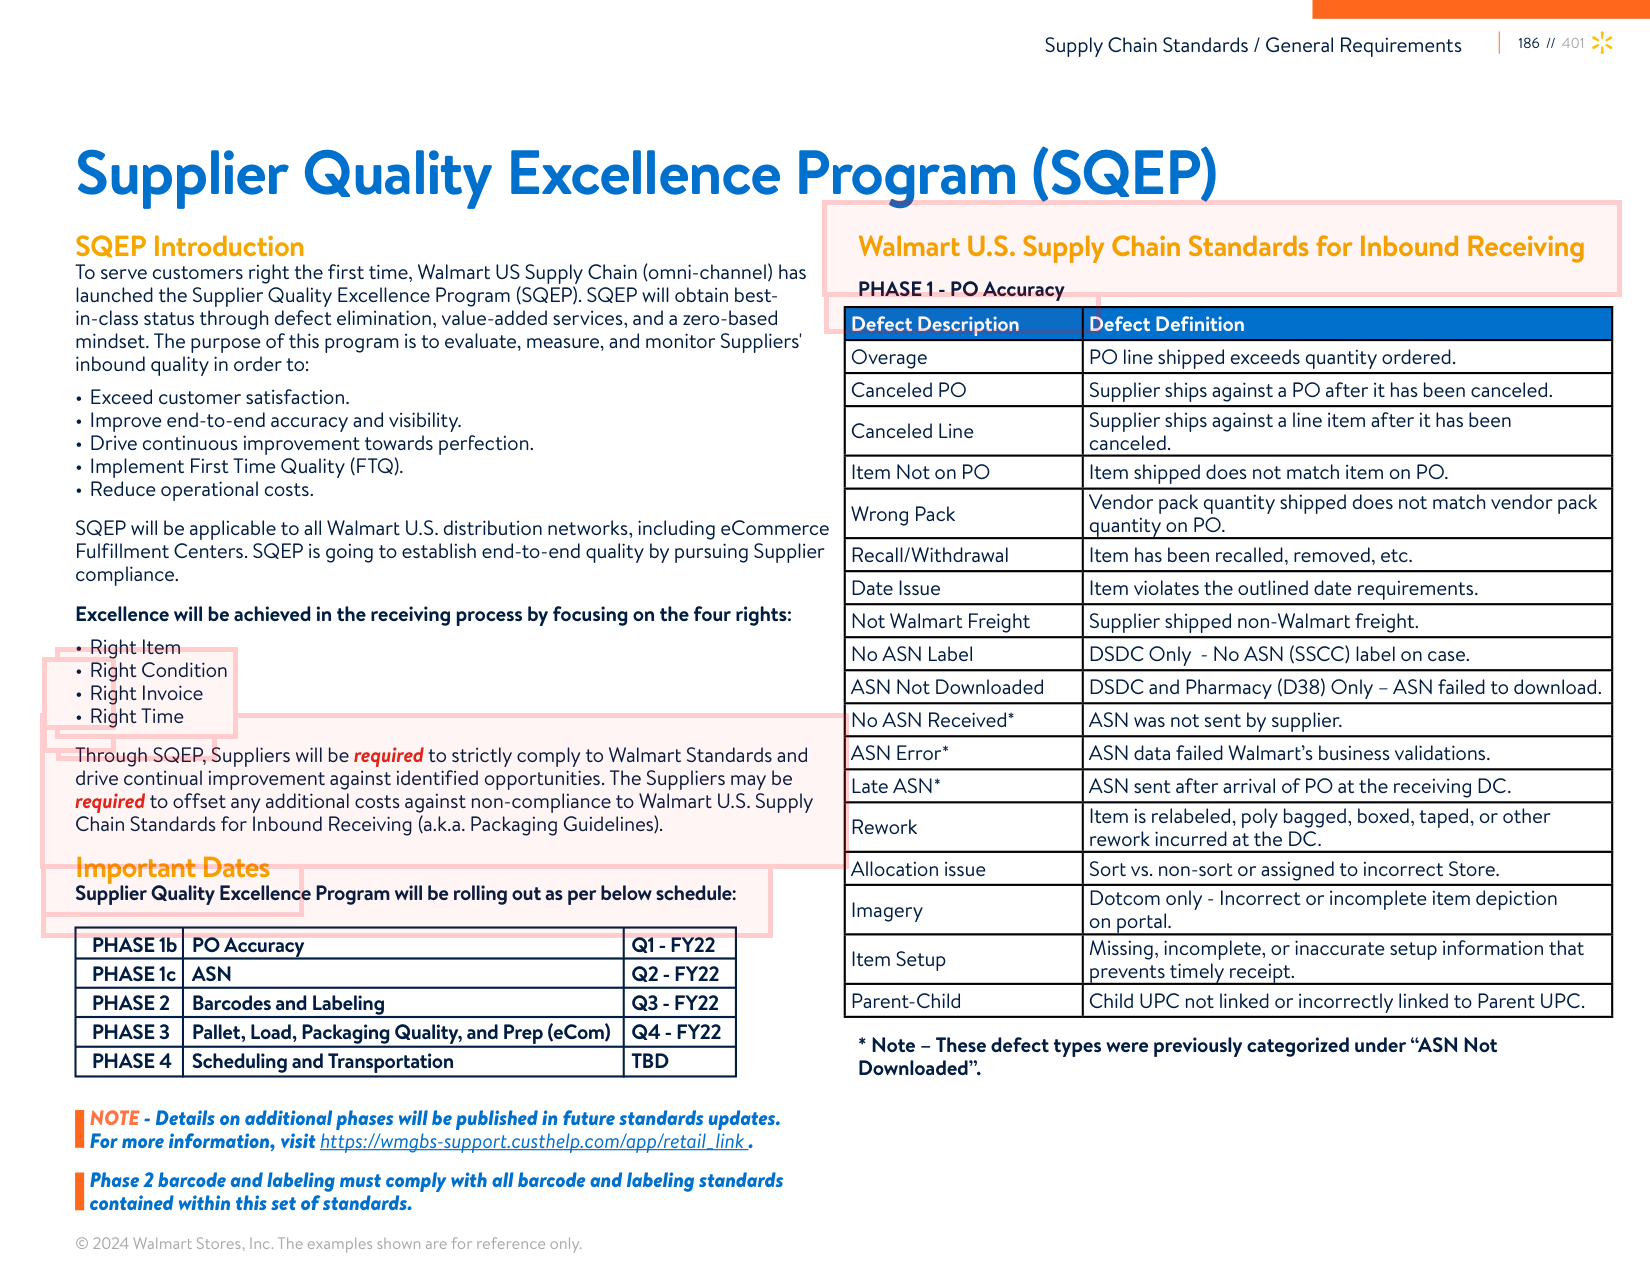

In [8]:
import fitz  # PyMuPDF
import requests
import hashlib
import os
from PIL import Image as PILImage, ImageDraw
from IPython.display import Image, display

import fitz  # PyMuPDF
import requests
import hashlib
import os
from PIL import Image as PILImage, ImageDraw
from IPython.display import Image, display

def render_page_of_pdf(url, page, bounding_boxes, render_dpi=150, padding=30):
    # Generate a unique filename based on the URL hash
    url_hash = hashlib.md5(url.encode()).hexdigest()
    pdf_filename = f"{url_hash}.pdf"

    # Download the PDF if it hasn't been saved locally yet
    if not os.path.exists(pdf_filename):
        response = requests.get(url)
        with open(pdf_filename, 'wb') as pdf_file:
            pdf_file.write(response.content)

    # Open the PDF
    doc = fitz.open(pdf_filename)

    # Check if the specified page exists
    if page < 1 or page > doc.page_count:
        print(f"Error: Page {page} does not exist in the PDF.")
        return

    # Render the page at the specified DPI
    pdf_page = doc.load_page(page - 1)  # PyMuPDF pages are zero-indexed
    scale_factor = render_dpi / 72
    render_matrix = fitz.Matrix(scale_factor, scale_factor)
    pix = pdf_page.get_pixmap(matrix=render_matrix)

    # Save the rendered page as an image
    output_image_path = "render.png"
    pix.save(output_image_path)

    # Open the image with Pillow and create a semi-transparent overlay
    img = PILImage.open(output_image_path)
    overlay = PILImage.new("RGBA", img.size, (255, 255, 255, 0))
    overlay_draw = ImageDraw.Draw(overlay)

    # Draw each bounding box in the list with opacity settings
    for bounding_box in bounding_boxes:
        top_left = (bounding_box['topLeftX'] - padding, bounding_box['topLeftY'] - padding)
        bottom_right = (bounding_box['bottomRightX'] + padding, bounding_box['bottomRightY'] + padding)

        olop = 50 if len(bounding_boxes) > 1 else 100
        fillop = 10 if len(bounding_boxes) > 1 else 50

        # Draw the filled rectangle with high opacity
        overlay_draw.rectangle([top_left, bottom_right], fill=(255, 0, 0, fillop))  # Red fill with 100/255 opacity

        # Draw the outline with lower opacity
        outline_width = 5
        for i in range(outline_width):
            overlay_draw.rectangle(
                [top_left[0] - i, top_left[1] - i, bottom_right[0] + i, bottom_right[1] + i],
                outline=(255, 0, 0, olop)  # Red outline with 200/255 opacity
            )

    # Composite the overlay onto the original image
    img = PILImage.alpha_composite(img.convert("RGBA"), overlay)

    # Save the image with bounding boxes overlay
    img = img.convert("RGB")  # Convert back to RGB before saving
    img.save(output_image_path)

page_data = qa_generation_data[2]

# Example usage:
render_page_of_pdf(
    url=page_data['documentUrl'],
    page=page_data['pageNumbers'][0],
    bounding_boxes=page_data['boundingBoxes']
)

# Display the image
display(Image(filename='render.png'))

# Creating a syncronous POC
The core components of QA pair generation with auditing visuals are there. Putting it all together to see how it looks.

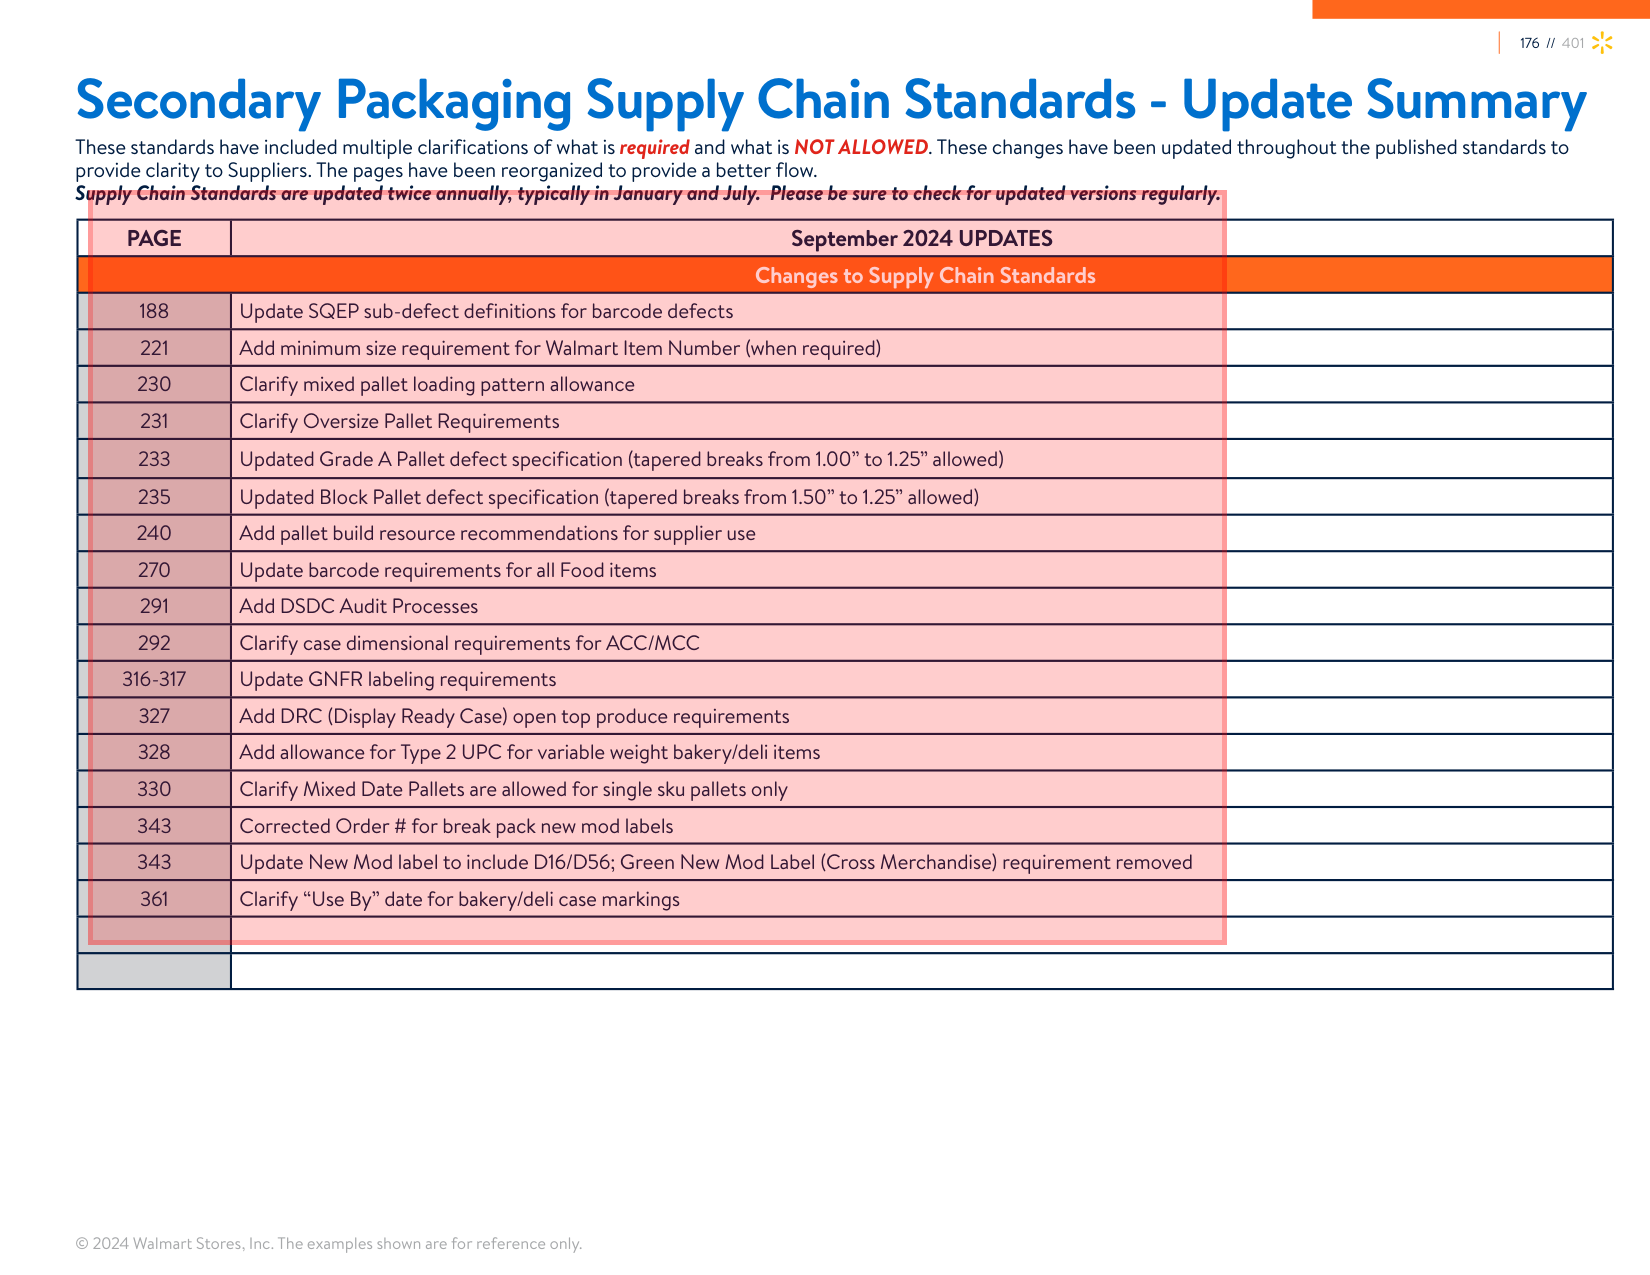

==== Rationale ====
The provided data includes a list of updates focusing on various aspects of Walmart's supply chain standards. It covers changes related to barcode requirements, pallet specifications, labeling requirements, and more, indicating a comprehensive restructuring of the guidelines. An information extraction system might struggle with identifying the specific context of these updates, particularly due to the qualitative nature of some updates and the specificity of certain terms (e.g., 'tapered breaks', 'DSDC audit processes'). Additionally, the system may have difficulties grouping similar updates or understanding the implications of these changes on operational compliance. The data illustrates a variety of topics, which should be leveraged to test understanding of specific details, as well as the ability to synthesize related information.
=== question 0 ===
Question: What is the update regarding the barcode requirements for food items?
Answer: Update barcode requirements

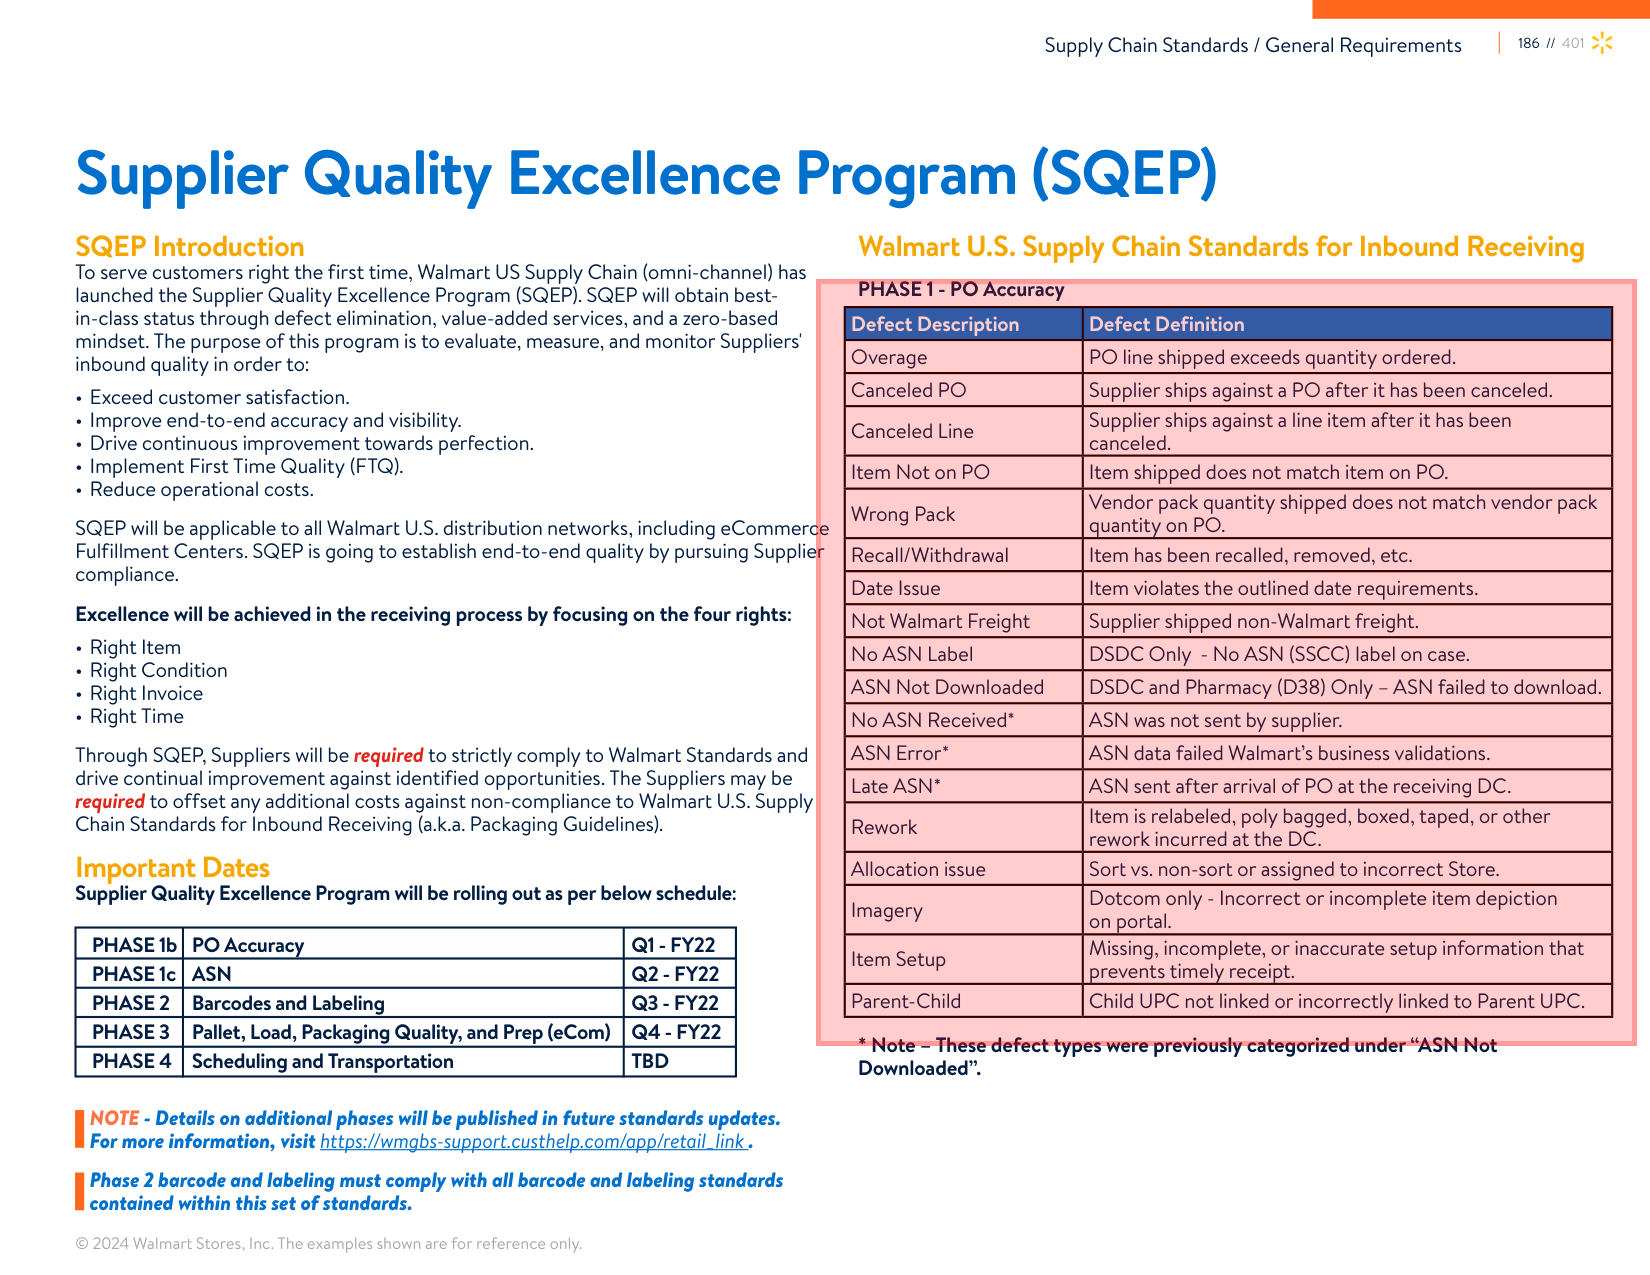

==== Rationale ====
The data presents a list of defect descriptions encountered in the supply chain, primarily related to order fulfillment and shipping processes. Each defect is accompanied by a specific definition that clarifies the nature of the issue. An information extraction system might struggle with distinguishing between similar defect descriptions, understanding the context of why certain defects occur, and grasping the implications of each defect on the supply chain and supplier compliance. It may also fail to recognize relationships between defects, such as how one defect might lead to another or affect overall supplier performance. The questions generated should cover a range of understanding from basic definition recall to implications of defects and relationships between them.
=== question 0 ===
Question: What does 'Overage' refer to in the context of defects?
Answer: Overage refers to a situation where the PO line shipped exceeds the quantity ordered.
=== question 1 ===

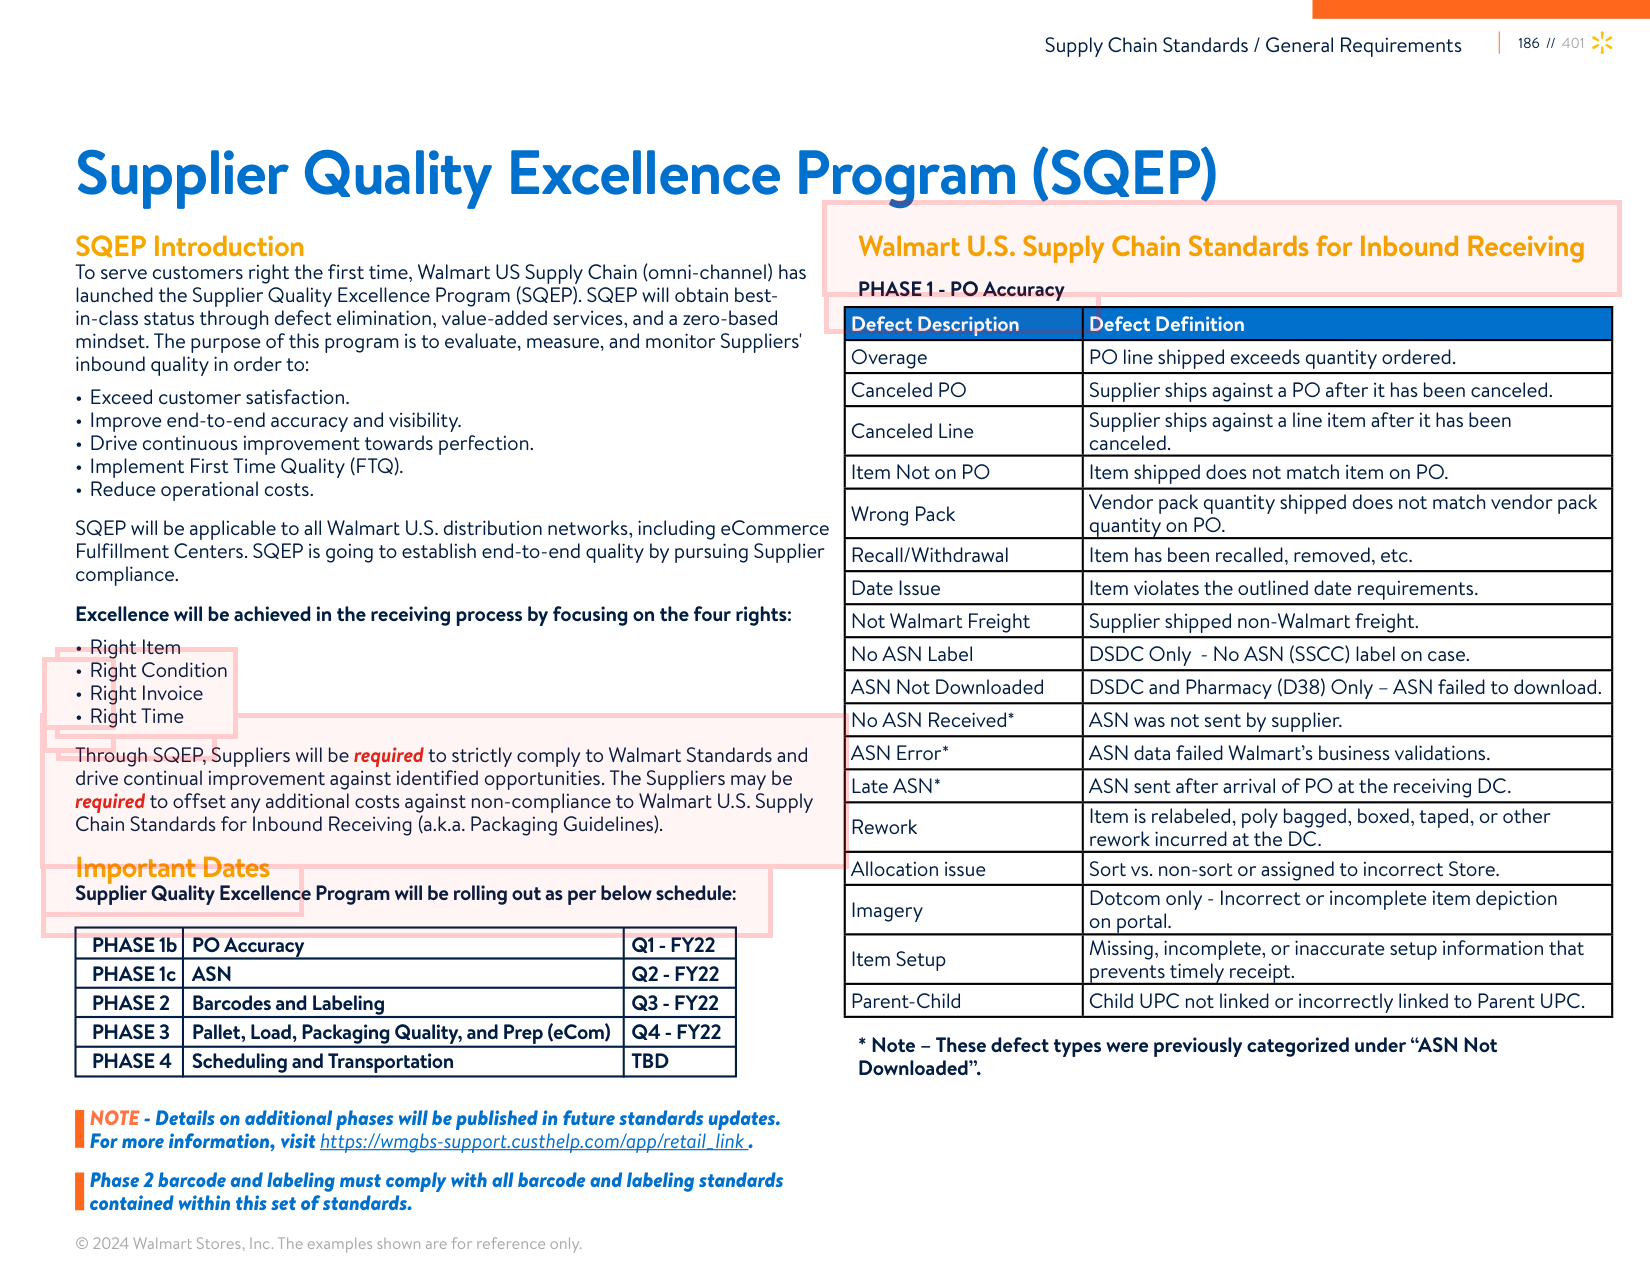

==== Rationale ====
The provided data discusses the requirements for suppliers in Walmart's Supplier Quality Excellence Program (SQEP), detailing aspects like invoice correctness, adherence to standards, continuous improvement, and the consequences of non-compliance. An information extraction system might struggle with understanding the implications of compliance versus non-compliance, the specifics of the timelines, or accurately identifying various phases of the program such as 'PHASE 1'. Moreover, the distinction between different standards and programs may be challenging. These areas necessitate comprehension beyond keyword extraction, demanding nuance in understanding operational standards and compliance guidelines.
=== question 0 ===
Question: What are suppliers required to ensure under Walmart's SQEP?
Answer: Suppliers must ensure the 'Right Invoice' and 'Right Time' in their operations.
=== question 1 ===
Question: What must suppliers adhere to in the SQEP?
Answer: Suppliers ar

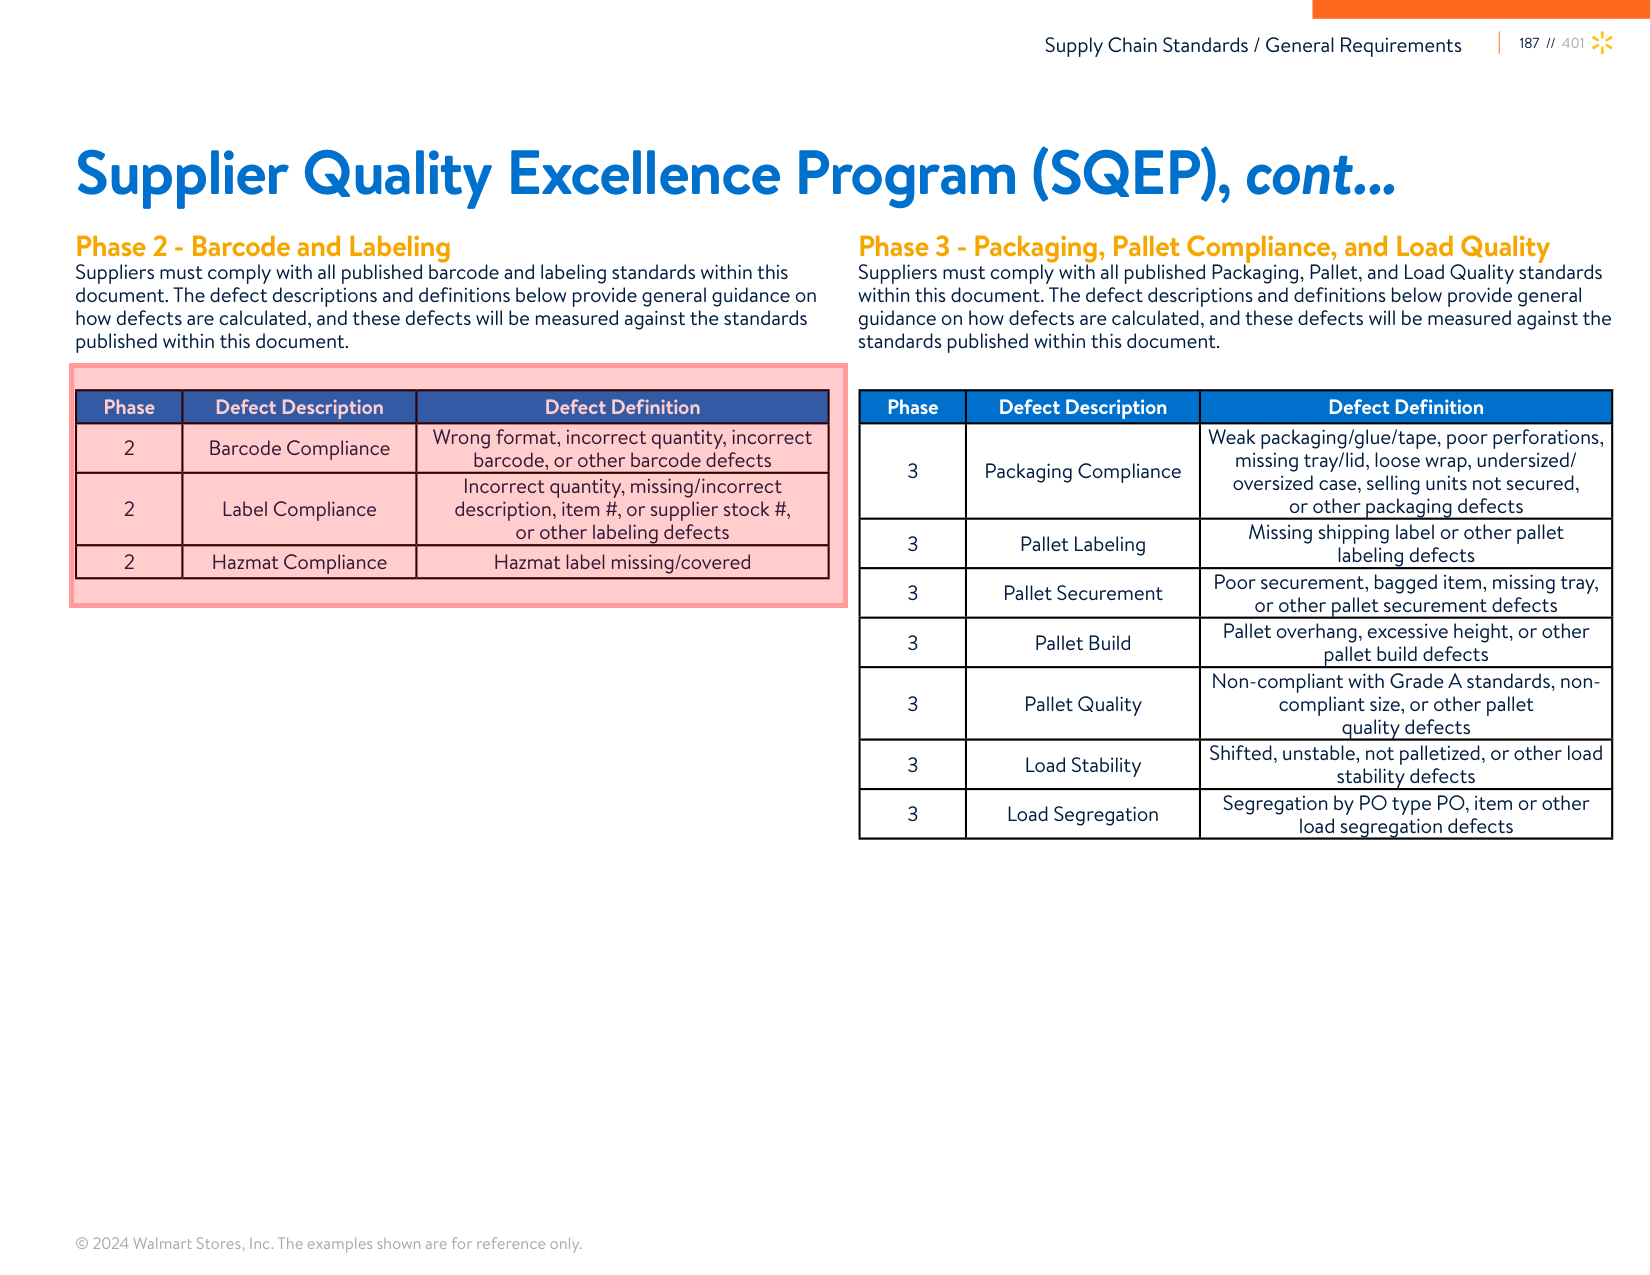

==== Rationale ====
The data presents information on compliance defects related to a specific phase of a quality program, categorizing each defect type and providing definitions of what constitutes a defect. An information extraction system may struggle with context-based question formatting, as many defect descriptions share similar keywords. Additionally, differentiating between closely related concepts, such as 'Label Compliance' vs 'Barcode Compliance', could pose a challenge, especially when identifying nuances in definitions. The questions should ideally probe these subtleties and the distinct nature of each defect type.
=== question 0 ===
Question: What are the three types of defects listed for Phase 2 in the Supplier Quality Excellence Program?
Answer: The three types of defects are Barcode Compliance, Label Compliance, and Hazmat Compliance.
=== question 1 ===
Question: What does 'Barcode Compliance' refer to in Phase 2 of the SQEP?
Answer: Barcode Compliance refers to defects

In [9]:
batch_queue = []

for _, qa_gen_data in enumerate(qa_generation_data):
    #generate more batches if queue is low
    if len(batch_queue) < 3:
        batch_queue.append(gen_qa_batch(qa_gen_data))

    #popping 0th batch
    batch = batch_queue.pop(0)

    #rendering page and rationale, which is valid accross the batch
    render_page_of_pdf(
        url=batch['documentUrl'],
        page=batch['pageNumbers'][0],
        bounding_boxes=batch['boundingBoxes']
    )

    display(Image(filename='render.png'))

    print('==== Rationale ====')
    print(batch['rationale'])


    for i, qa in enumerate(batch['questions_answers']):
        print(f'=== question {i} ===')
        print(f'Question: {qa["question"]}')
        print(f'Answer: {qa["answer"]}')

        #TODO ability to edit question and answer.
        #ability to save question and answer, allong with all dat associated.
        #ability to discard question and answer
        #ability to skip to the next batch

    if _>2:
        break

# Creating Core Application
This uses functionality previously defined, wrapped in a multithreaded application. This allows the user to interact while Q/A pairs are generated on the fly in the background.

View the output cell full screen (the little box with the arrow at the top left of the output block) for slightly better ux.

When ready, run the next cell to see Q/A pairs.

Waiting for new batches to be generated...



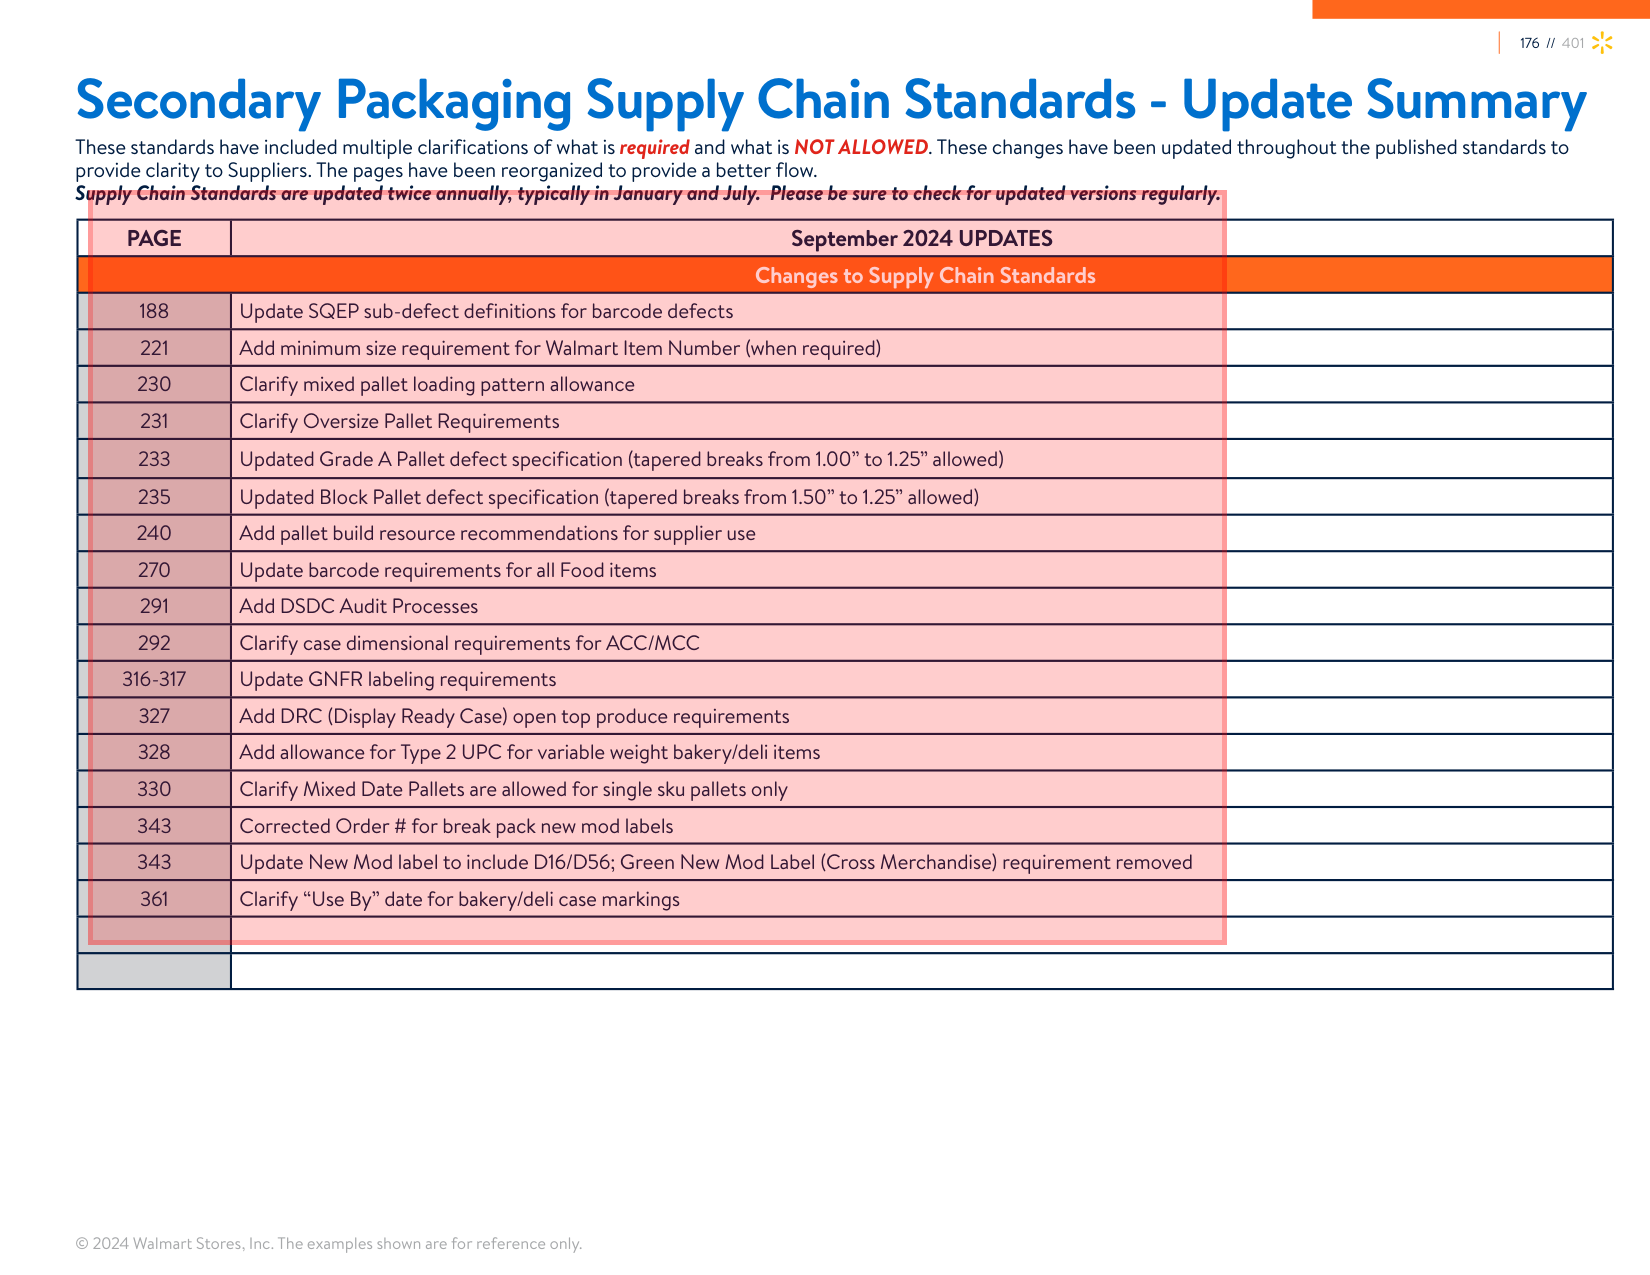


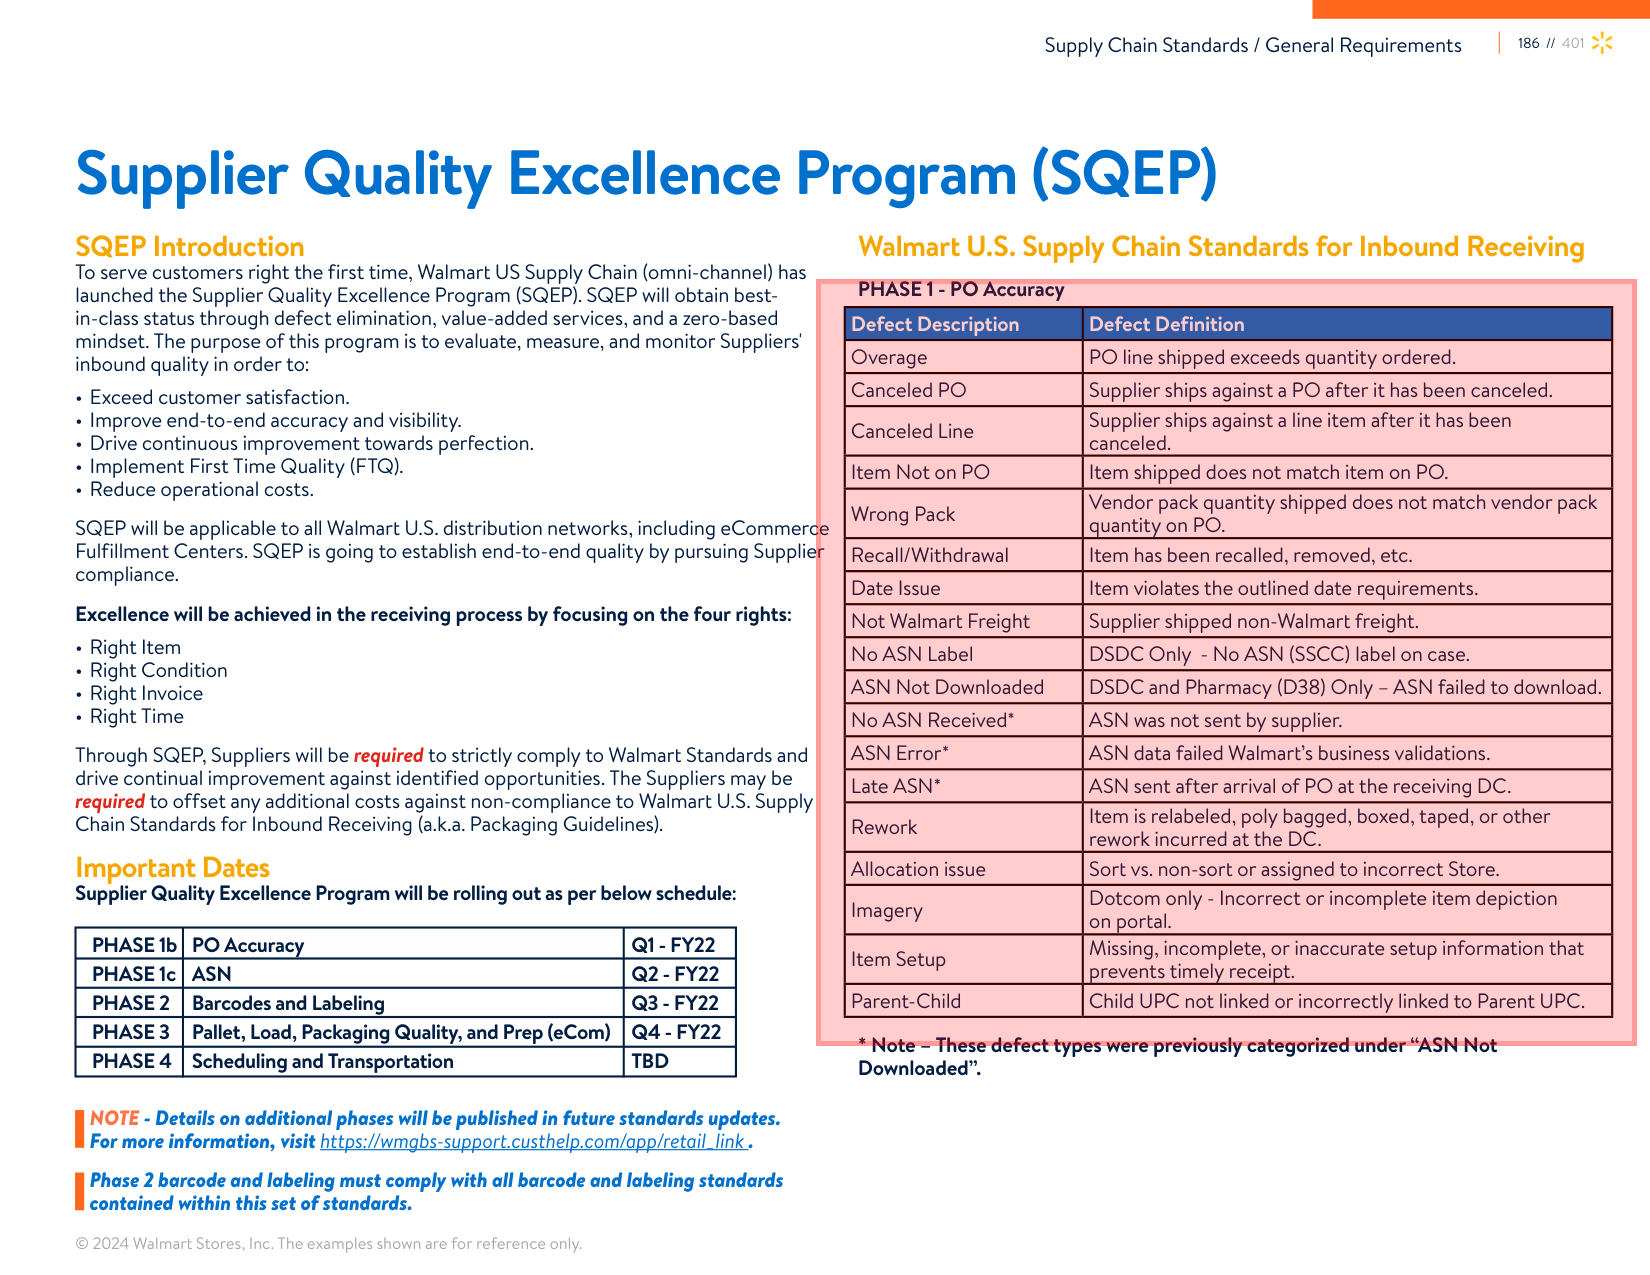


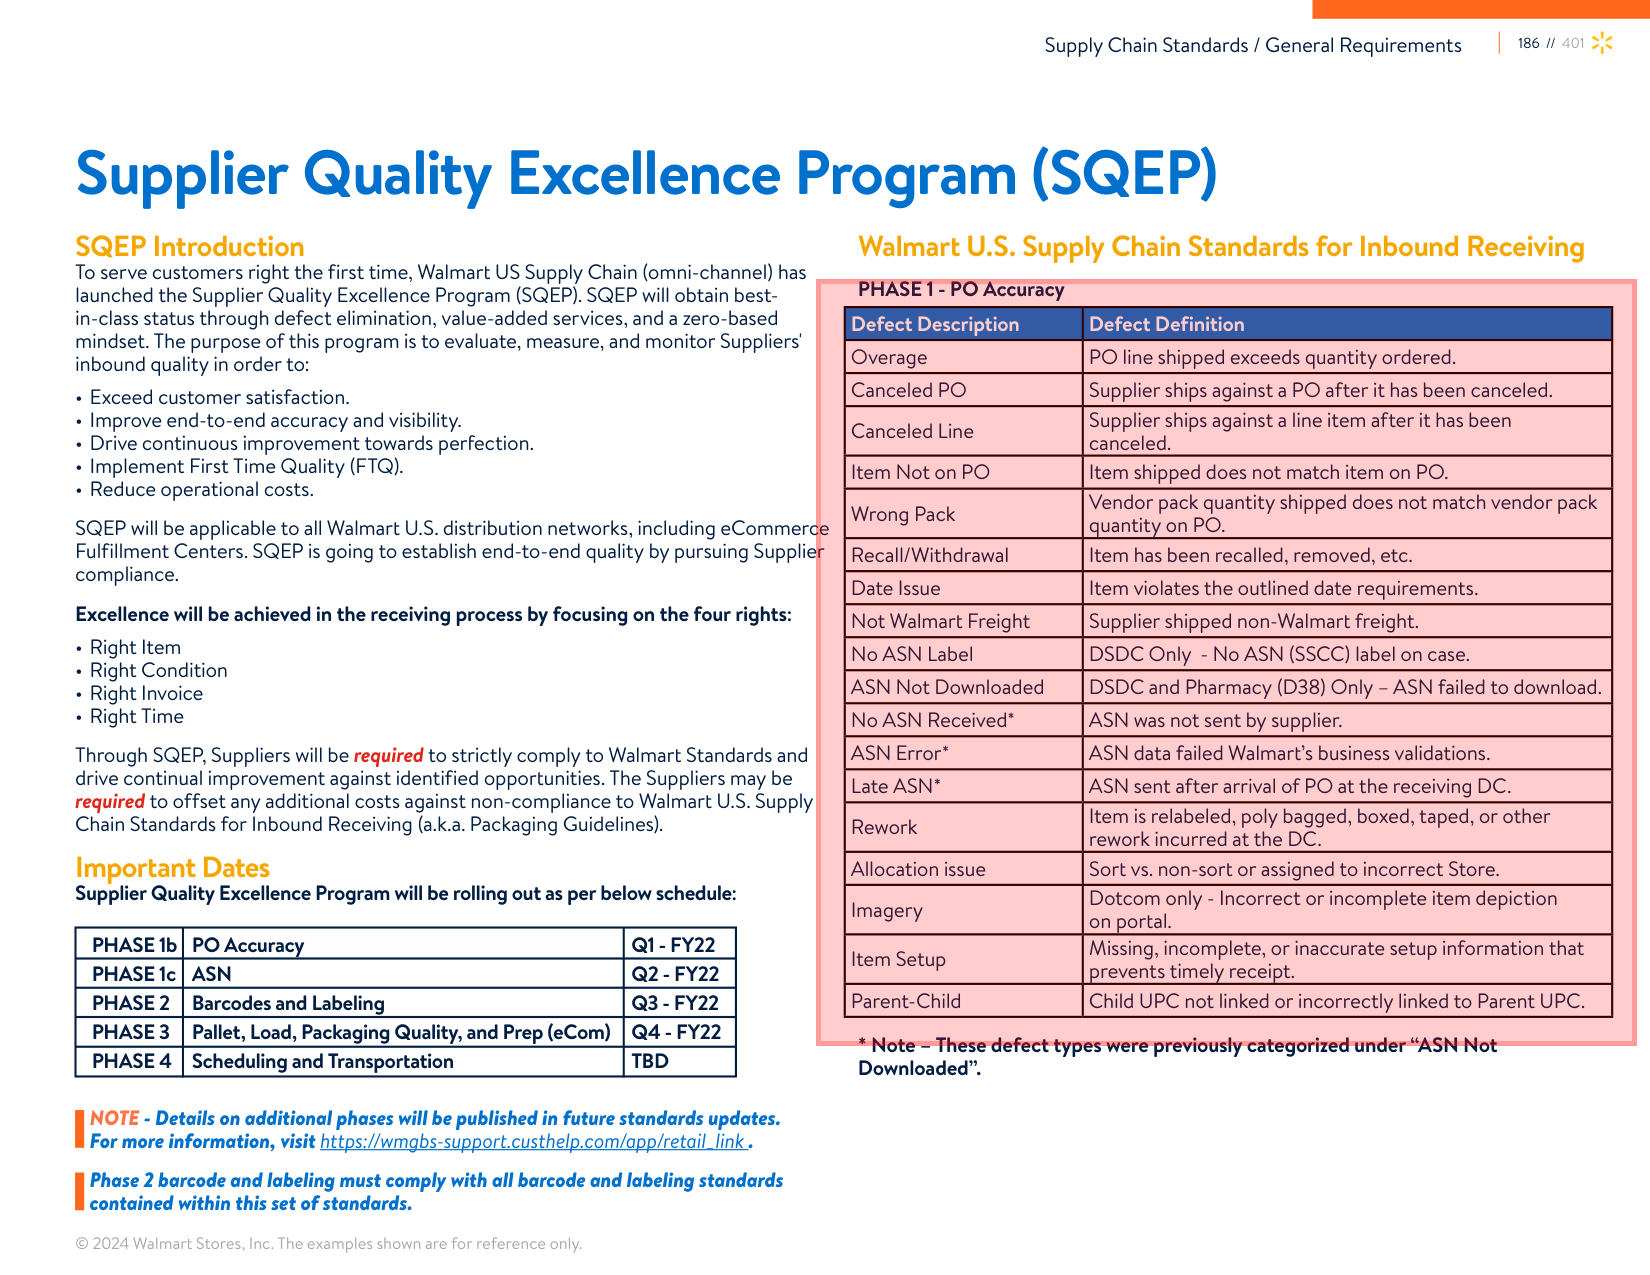


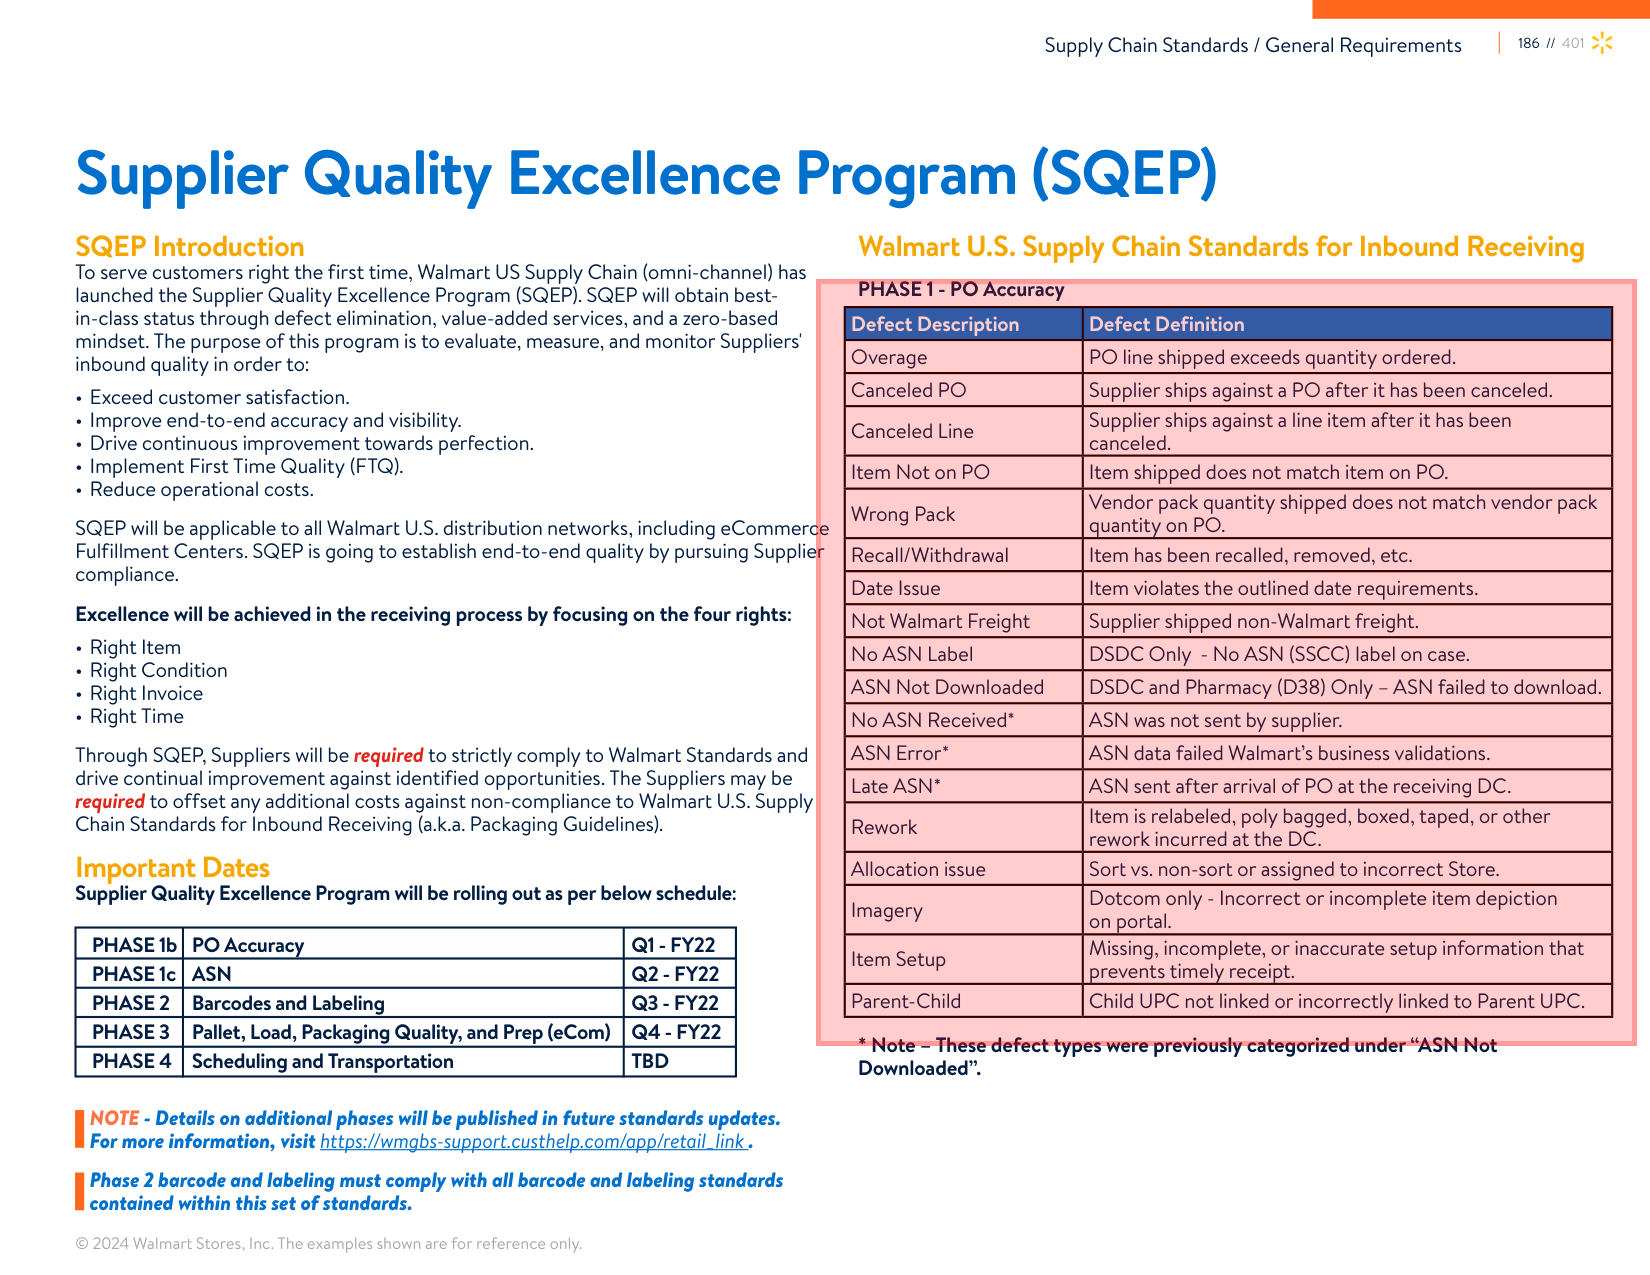


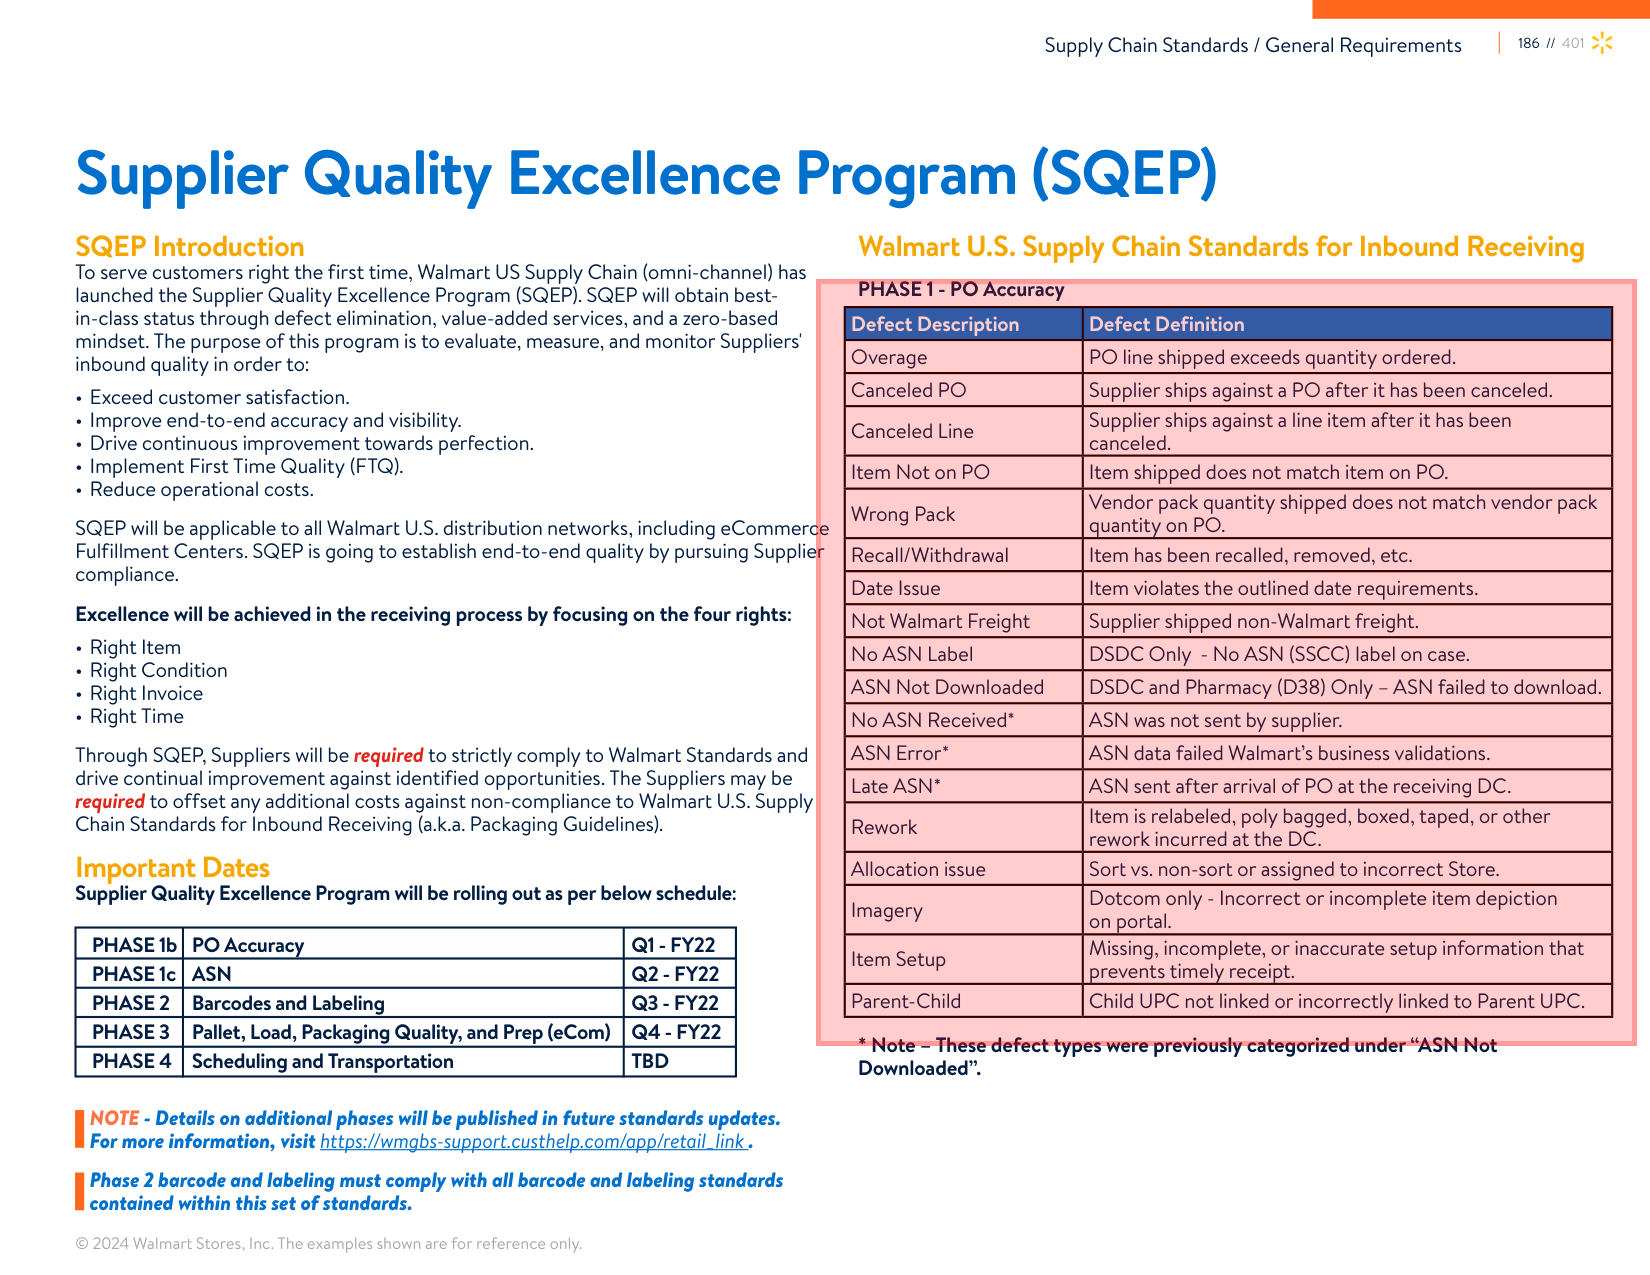

In [26]:
import pandas as pd
from IPython.display import display, HTML, Javascript
import threading
import time
import os
import base64
from PIL import Image
from io import BytesIO

# Initialize a queue and DataFrame for storing accepted answers (no saving in this version)
batch_queue = []
current_question_index = 0  # Tracks the question within the current batch
accepted = []

# Background process to keep batch queue populated
def batch_generator():
    for _, qa_gen_data in enumerate(qa_generation_data):
        if len(batch_queue) < 20:
            batch_queue.append(gen_qa_batch(qa_gen_data))
        time.sleep(1)  # Adjustable sleep time

# Start the batch generator thread
batch_gen_thread = threading.Thread(target=batch_generator, daemon=True)
batch_gen_thread.start()

# Function to render the page of the document and save it as an image
def render_page(batch):
    render_page_of_pdf(
        url=batch['documentUrl'],
        page=batch['pageNumbers'][0],
        bounding_boxes=batch['boundingBoxes']
    )

    # Wait until render.png is fully created before proceeding
    while not os.path.exists("render.png"):
        time.sleep(0.1)

# Function to convert render.png to base64 format for embedding
def get_image_base64():
    with open("render.png", "rb") as image_file:
        image_data = image_file.read()
        image_base64 = base64.b64encode(image_data).decode('utf-8')
    return image_base64

# Enhanced HTML and JavaScript for UI with improved styling and no editing functionality
def render_ui(batch, qa_pair):
    # Render and show the document page
    render_page(batch)

    # Convert render.png to base64 for embedding
    image_base64 = get_image_base64()

    display(
        HTML(f"""
        <style>
            .container {{
                max-width: 700px;
                margin: 20px auto;
                padding: 20px;
                font-family: Arial, sans-serif;
                background-color: #ffffff;
                border: 1px solid #ddd;
                border-radius: 8px;
                box-shadow: 0 4px 8px rgba(0, 0, 0, 0.1);
            }}
            .image-container {{
                display: flex;
                justify-content: center;
                margin-bottom: 20px;
            }}
            .image-container img {{
                max-width: 100%;
                border-radius: 4px;
                border: 1px solid #ccc;
            }}
            .content {{
                text-align: left;
                color: #333;
            }}
            .content h3 {{
                color: #444;
            }}
            .actions {{
                text-align: center;
                margin-top: 20px;
            }}
            .actions button {{
                padding: 10px 15px;
                margin: 5px;
                background-color: #007BFF;
                color: white;
                border: none;
                border-radius: 4px;
                cursor: pointer;
            }}
            .actions button:hover {{
                background-color: #0056b3;
            }}
        </style>
        <div class="container">
            <div class="image-container">
                <img src="data:image/png;base64,{image_base64}" alt="Rendered Page">
            </div>
            <div class="content">
                <h3>Rationale</h3>
                <p>{batch['rationale']}</p>
                <h3>Question</h3>
                <p>{qa_pair['question']}</p>
                <h3>Answer</h3>
                <p>{qa_pair['answer']}</p>
            </div>
            <div class="actions">
                <button onclick="acceptQA()">Accept</button>
                <button onclick="skipQA()">Skip</button>
                <button onclick="skipBatch()">Skip Batch</button>
                <button onclick="stopEvaluation()">Stop</button>
            </div>
        </div>
        <script>
            function acceptQA() {{
                google.colab.kernel.invokeFunction('notebook.accept_qa', [], {{}});
            }}

            function skipQA() {{
                google.colab.kernel.invokeFunction('notebook.skip_qa', [], {{}});
            }}

            function skipBatch() {{
                google.colab.kernel.invokeFunction('notebook.skip_batch', [], {{}});
            }}

            function stopEvaluation() {{
                google.colab.kernel.invokeFunction('notebook.stop_evaluation', [], {{}});
            }}
        </script>
        """)
    )

# Callback functions for handling user actions
def accept_qa():
    accepted.append(batch_queue[0]['questions_answers'][current_question_index])
    skip_qa()

def skip_qa():
    global current_question_index
    batch = batch_queue[0]

    # Advance to the next question within the batch or move to the next batch if complete
    if current_question_index < len(batch['questions_answers']) - 1:
        current_question_index += 1
        display_next_qa()
    else:
        current_question_index = 0
        skip_batch()

def skip_batch():
    global current_question_index
    if batch_queue:
        batch_queue.pop(0)
    current_question_index = 0
    display_next_batch()

def stop_evaluation():
    print("Evaluation stopped.")

# Helper functions to update UI without clearing the entire cell
def display_next_qa():
    if batch_queue:
        batch = batch_queue[0]
        qa_pair = batch['questions_answers'][current_question_index]
        render_ui(batch, qa_pair)
    else:
        print("Waiting for new batches to be generated...")
        wait_for_batch()

def display_next_batch():
    display_next_qa()

def wait_for_batch():
    while not batch_queue:
        time.sleep(1)
    display_next_batch()

# Register the callback functions
from google.colab import output
output.register_callback('notebook.accept_qa', accept_qa)
output.register_callback('notebook.skip_qa', skip_qa)
output.register_callback('notebook.skip_batch', skip_batch)
output.register_callback('notebook.stop_evaluation', stop_evaluation)

# Display the first batch and QA pair
display_next_batch()

In [24]:
accepted

[{'question': 'What update was made on page 188 of the September 2024 updates?',
  'answer': 'Update SQEP sub-defect definitions for barcode defects.'},
 {'question': 'What minimum size requirement was added for Walmart Item Number as per page 221?',
  'answer': 'Add minimum size requirement for Walmart Item Number (when required).'},
 {'question': 'Which update clarifies mixed pallet loading pattern allowance, and on what page can it be found?',
  'answer': 'Clarify mixed pallet loading pattern allowance is on page 230.'},
 {'question': "What is the definition of 'Overage'?",
  'answer': 'PO line shipped exceeds quantity ordered.'}]